# Meituan AppSpider
- Author: Yiran Jing

Build Meituan AppSpider to collect customer comments of 'Macaroni of Zhang grandpa' chain restaurants

Scraping content:
1. Store location（店铺地址）
2. Score of store （店铺评分）
3. Consumption per person （人均消费）
4. Business Hours （营业时间）
5. Customer comments (网友点评)
6. Recommended dishes (推荐菜)


Reference: 

1. https://github.com/hahaha108/meituanAppSpider
2. https://blog.csdn.net/slphahaha/article/details/81145404


In [1]:
import requests
import json
from lxml import etree
import pandas as pd
import re
import math
import urllib
import urllib.request as urllib2
import xlsxwriter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
import csv

### ShenZhen Area
- 目前美团有两个店铺，但是暂时都无评论

### Shanghai Area

- 爬取上海地区张爷爷空心面的美团信息
- 上海地区有五个连锁店铺,但目前只有两个店铺有用户评价，所以暂时只抓了两个店铺

In [2]:
from spider_develop_shanghai import MeituanSpider_shanghai

# save_mode ：txt存储为txt文件，csv存储为csv文件，无输入默认为csv
spider_shanghai = MeituanSpider_shanghai()
taglist_1, commentslist_1 = spider_shanghai.run(1000) # max read 10 pages, 10 comments in each page

Spider is ready for shanghai area


### Nanjing Area
- 目前美团有两个店铺
- 只有一个店铺有一则评论, 暂不抓取

### TaiYuan Area
- 目前美团有一家店铺：（茂业中心店）

In [3]:
from spider_develop_taiyuan import MeituanSpider_taiyuan

# save_mode ：txt存储为txt文件，csv存储为csv文件，无输入默认为csv
spider_taiyuan = MeituanSpider_taiyuan()
taglist_2, commentslist_2 = spider_taiyuan.run(1000)

Spider is ready for Taiyuan area


### TaiCang area
- 目前美团有一家店铺：

In [4]:

from spider_develop_taicang import MeituanSpider_taicang

# save_mode ：txt存储为txt文件，csv存储为csv文件，无输入默认为csv
spider_taicang = MeituanSpider_taicang()
taglist_3, commentslist_3 = spider_taicang.run(1000)

Spider is ready for Taicang area


## Save result to csv

In [5]:
taglist = taglist_1 + taglist_2 + taglist_3
commentslist = commentslist_1 + commentslist_2 + commentslist_3

In [6]:
def Write_to_csv(fieldKey, file_name,datalist):
    with open(file_name, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames= fieldKey)
        writer.writeheader()
        for data in datalist:
            writer.writerow(data)

In [7]:
## Write user comments detail to csv
fieldkey = ['店名',"用户名", '平均消费','星级','菜单','评价时间','用餐结束时间','评价']
file_name = 'meituanZhangYeyeInfos/Zhangyeye_Comments_ShangHai.csv'
Write_to_csv(fieldkey, file_name, commentslist)

In [8]:
## Write tag retails to csv file
fieldKey = ['标签','累计数量']
file_name = "meituanZhangYeyeInfos/Zhangyeye_Tags_shanghai.csv"
Write_to_csv(fieldKey, file_name, taglist)

In [9]:
df  = pd.read_csv("meituanZhangYeyeInfos/Zhangyeye_Tags_shanghai.csv")
## merge counts if they have same tags 
aggregation_functions = {'标签': 'first','累计数量': 'sum'}
df_new = df.groupby(df['标签']).aggregate(aggregation_functions)
df_new.to_csv('meituanZhangYeyeInfos/Zhangyeye_Tags_shanghai.csv',index=False)

In [10]:
tags_info  = pd.read_csv("meituanZhangYeyeInfos/Zhangyeye_Tags_shanghai.csv")
tags_info.head()

,标签,累计数量
0,上菜快,7
1,价格实惠,9
2,体验很棒,4
3,分量足,12
4,午餐,8


## Create Wordcloud with Chinese

### Tags 

In [11]:
import jieba # to support chinese
jieba.enable_parallel(4)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1l/pfc4n6891k7350ty2zvn2mx40000gn/T/jieba.cache
Loading model cost 0.745 seconds.
Prefix dict has been built succesfully.


In [12]:
bag = tags_info

In [13]:
bag

,标签,累计数量
0,上菜快,7
1,价格实惠,9
2,体验很棒,4
3,分量足,12
4,午餐,8
5,味道赞,32
6,回头客,3
7,干净整洁,5
8,性价比高,13
9,拔草,3


In [14]:
file = open("meituanZhangYeyeInfos/tags.txt","w")
for index,row in tags_info.iterrows():
    for i in range(row['累计数量']): 
        file.write(row['标签'])
        file.write(" ")
file.close() 


In [15]:
text = open('meituanZhangYeyeInfos/tags.txt', 'r',encoding= 'UTF-8-sig').read()
#text

In [16]:
text = ' '.join(jieba.cut(text))

In [17]:
from PIL import Image
import numpy as np
icon_path = 'fonts/heart.png'
icon = Image.open(icon_path)
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

In [18]:
import jieba
from scipy.misc import imread

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple([255,255,255]) # RGB code of white color

from wordcloud import ImageColorGenerator
color_func = ImageColorGenerator(mask)


# indicate the font path that can display Chinese
font_filename = 'fonts/STFangSong.ttf'

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path=font_filename, background_color="white", max_words=2000, mask = mask, max_font_size=300, random_state=1)
wc.generate_from_text(text)
wc.recolor(color_func=color_func, random_state=2)
# save as png
output_path = 'wordcloud.png'
wc.to_file(output_path)
# display the word cloud
plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(wc)
plt.axis("off")
plt.show()

<Figure size 1200x1200 with 1 Axes>

### Most popular Menu
Analysis the most popular dishes

In [19]:
#commentslist
comments  = pd.read_csv("meituanZhangYeyeInfos/Zhangyeye_Comments_ShangHai.csv")
comments.head()

,店名,用户名,平均消费,星级,菜单,评价时间,用餐结束时间,评价
0,上海世纪汇店铺,不凡帝范梅勒丶,30,50,番茄牛腩空心面1份,1550841341134,1.552654e+09,上过舌尖的空心面果然名不虚传！味道口感一级棒！而且用团购足足可以省下8块1毛钱。番茄牛腩味道...
1,上海世纪汇店铺,girlman敏,30,40,番茄牛腩空心面1份,1546077431869,1.552654e+09,在1992弄里面的超级有老上海的感觉，跟朋友一起在那个底下吃了些小零食啥的 这个面门口写的舌...
2,上海世纪汇店铺,jYM629694080,30,50,番茄牛腩空心面1份,1541086875863,1.552654e+09,“1192弄老上海风情街”位于浦东世纪大道地铁站的世纪汇广场内，这里现在已成了上海的网红地，...
3,上海世纪汇店铺,SZD486724107,30,50,NaN,1556537967473,NaN,味道蛮正，下次再来
4,上海世纪汇店铺,vwi406732198,30,50,NaN,1554891584937,NaN,味道不错


In [20]:
## fill missing value
comments['菜单'] = comments['菜单'].fillna('缺失') 
comments['星级'] = comments['星级'].fillna('missing') 
comments['平均消费'] = comments['平均消费'].fillna('missing') 

In [21]:
comments['菜单'].value_counts()

缺失                  13
全部菜品2选1，提供免费WiFi    10
番茄牛腩空心面1份            7
单人套餐A，提供免费WiFi       7
30元代金券1张，可叠加         2
Name: 菜单, dtype: int64

In [38]:
len(comments['菜单'])

39

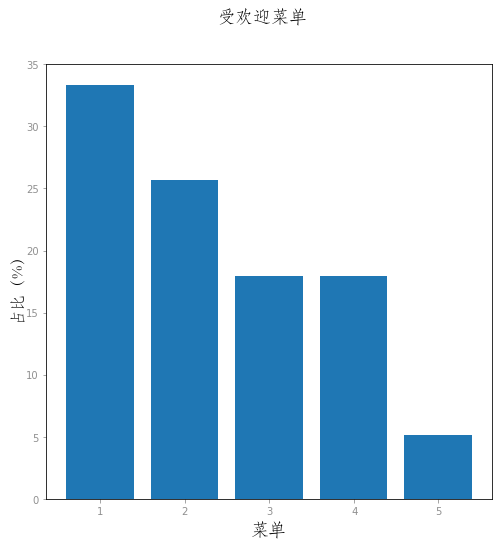

In [45]:
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

# 调整package可以显示中文
chinesefont = matplotlib.font_manager.FontProperties(fname='fonts/STFangSong.ttf')


fig,ax = plt.subplots()
tick_labels = ['1', '2', '3', ' 4', '5']
plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(5), comments['菜单'].value_counts()*100/len(comments['菜单']),
       tick_label=tick_labels, align='center'
       )
fig.suptitle(u'受欢迎菜单', fontproperties=chinesefont, fontsize=18)
plt.xlabel(u'菜单',fontproperties=chinesefont,fontsize=18)  
plt.ylabel(u'占比（%）',fontproperties=chinesefont,fontsize=16)  
plt.show()   

由于代码无法显示中文，我用数字表示
1.  全部菜品2选1，提供免费WiFi
2.  番茄牛腩空心面1份   
3. 单人套餐A，提供免费WiFi
4.   30元代金券1张，可叠加
5. 数据缺失

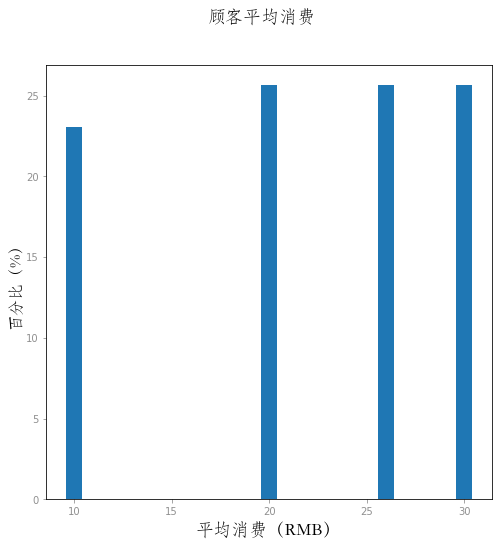

In [47]:

fig,ax = plt.subplots()

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(comments['平均消费'].unique(),comments['平均消费'].value_counts()*100/len(comments['平均消费']))
fig.suptitle(u'顾客平均消费', fontproperties=chinesefont, fontsize=18)
plt.xlabel(u'平均消费（RMB）',fontproperties=chinesefont,fontsize=18)  
plt.ylabel(u'百分比（%）',fontproperties=chinesefont,fontsize=16)  
plt.show()   



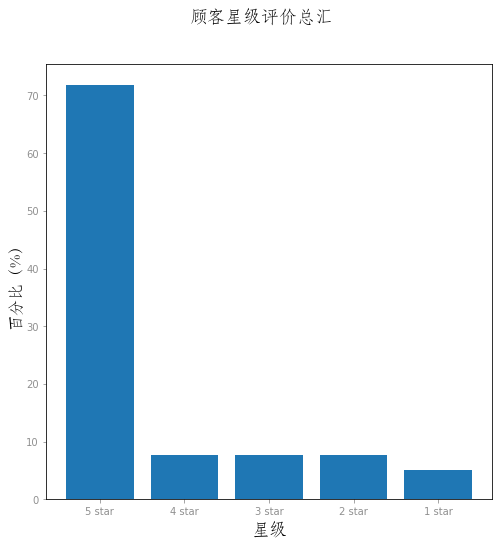

In [53]:
fig,ax = plt.subplots()

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(["5 star",'4 star','3 star','2 star','1 star'],comments['星级'].value_counts()*100/len(comments['星级']))
fig.suptitle(u'顾客星级评价总汇', fontproperties=chinesefont, fontsize=18)
plt.xlabel(u'星级',fontproperties=chinesefont,fontsize=18)  
plt.ylabel(u'百分比（%）',fontproperties=chinesefont,fontsize=16)  
plt.show()   

